# Multiclass Classification Models in Keras

**Objective:** 
- Preprocess a multiclass target for a Keras deep learning model.
- Create a feed-forward model for multiclass classification using appropriate output layers, loss functions, and metrics in Keras.
- Evaluate a feed-forward multiclass classification model created in Keras using Sci-Kit Learn metric functions.

As you recall, a classification problem is one in which you are trying to predict a discrete, finite, and non-overlapping number of classes. Multiclass classification is when you are trying to predict which of 3 or more classes a sample belongs to. This is handled a little differently in Keras models than binary classification, although most of the same metrics can apply. One example is a model that tries to classify fish into a limited number of known species using measurements of size and weight. Let’s try this in Keras.

**In this lesson, we will:**
1. Import necessary libraries.
2. One-hot encode the target variable.
3. Load and process the data.
4. Build a feed-forawrd multiclass classification model with an appropriate output layer and loss function.
5. Evaluate the model using classification metrics and a confusion matrix.

## Libraries, functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
 
#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [3]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

## Load and preprocess data

The data we will be using is collected from a fish market and represents data about nine different common fish species. It was originally downloaded from Kaggle​​.

This dataset only has 159 rows, and that would usually be too small for deep learning to be effective. However, it will work for demonstration purposes.

In [4]:
# Load Data
multi_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR_I2xiiboTvyDr5-Cvvo_m7tnoT2tVnzOWUYf2xBZEhTWiWtZOyerF3c2aQeym10S8T2yHnTPnlPi2/pub?output=csv'
df_multi = pd.read_csv(multi_url)
df_multi.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [5]:
# Check for duplicates and missing data
print(df_multi.info())
print(f'{df_multi.duplicated().sum()} duplicate rows')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  155 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  157 non-null    float64
 3   Length2  157 non-null    float64
 4   Length3  150 non-null    float64
 5   Height   156 non-null    float64
 6   Width    157 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB
None
0 duplicate rows


Other than the target, all of the columns are numeric, and there are no duplicates. However, we have some rows with missing values. Let’s see how many rows are missing at least one value.

In [6]:
# count rows with missing values
na_rows = df_multi.isna().any(axis=1).sum()
print(f'{na_rows} rows are missing data')
print(f'{na_rows/len(df_multi)*100:.1f}% of rows are missing data')

20 rows are missing data
12.6% of rows are missing data


**NOTE:**
This is more than 10%, and normally, we would try to impute these. Alternatively, we can choose to drop them.  We will try dropping them, but if we continue with this project, we might try both versions of the data, with dropped nulls and imputed nulls, to see which trains a better model.

In [7]:
# drop missing data
df_multi.dropna(inplace=True)
print(df_multi.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 157
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  139 non-null    object 
 1   Weight   139 non-null    float64
 2   Length1  139 non-null    float64
 3   Length2  139 non-null    float64
 4   Length3  139 non-null    float64
 5   Height   139 non-null    float64
 6   Width    139 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.7+ KB
None


Since we are performing classification, we should always check our class balance to help us make decisions about data preparation and to help us properly interpret our accuracy scores.

In [8]:
# check class balance
df_multi['Species'].value_counts()

Perch        48
Bream        30
Roach        16
Pike         13
Smelt        13
Parkki       11
Whitefish     6
Beam          2
Name: Species, dtype: int64

Our training set is very imbalanced. We could apply some balancing techniques, but with so few training instances, it would be pointless to oversample or undersample the data. We could try SMOTE, but we might expect limited success. In this case, we will leave it and see how our model performs. We can also expect our accuracy score to be unreliable in measuring our model’s performance.​

There are also only 2 ‘Beam’ fish in the dataset. A Google search shows that there is no fish named a ‘Beam’. We will combine this with ‘Bream’

In [9]:
df_multi['Species'].replace('Beam', 'Bream', inplace=True)

Next, we will split the data into X features and y target and training and validation sets.

In [10]:
# split data
X = df_multi.drop(columns='Species')
y = df_multi['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y)

Data features for deep learning should always be scaled to avoid exploding weights. Exploding weights cause some weights to grow very large and be given too much emphasis by the model. This can lead to overfitting problems.

In [11]:
# scale data
scaler = StandardScaler()
 
X_train_tf = scaler.fit_transform(X_train)
X_test_tf = scaler.transform(X_test)

## Encode the target

One important difference between binary and multiclass classifications is how we encode the target. In binary classification, we need to ensure that the two classes are encoded as 0 and 1.

In multiclass classification, we both numerically encode and one-hot encode, or binarize, the target.

We will end up with 3 versions of the labels: original, numerically encoded, and binarized.

In [12]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# encode labels
encoder = LabelEncoder()
 
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)
 
# make a record of the classes, in order of the encoding, in case we want to 
# translate predictions into fish names later.
classes = encoder.classes_
 
# binarize labels
binarizer = LabelBinarizer()
 
binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)
 
# check results
print('Original Target')
print(y_train.head())
 
print('\nEncoded Target')
print(y_train_enc[:5])
 
print('\nBinarized Target')
print(y_train_bin[:5])

Original Target
36     Roach
27     Bream
126    Perch
73     Perch
34     Bream
Name: Species, dtype: object

Encoded Target
[4 0 2 2 0]

Binarized Target
[[0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]


## Create the Keras Model

We are ready to create our model architecture. We will set the input dimensions to the number of features in the incoming training data so Keras can create the correct implied input layer.

In [13]:
# Define input shape
input_shape = X_train_tf.shape[1]
input_shape

6

Some previous experiments have shown us that we need a model with some complexity, two hidden layers with 50 nodes each, but that complexity also can lead to overfitting problems. We will use dropout layers to regularize our model to combat overfitting.

**Output Layer**

In [14]:
# Define number of classes
num_classes = len(classes)
num_classes

7

The number of nodes in the output layer must match the number of classes in the target. In this case, we are classifying fish into 7 different species, so the output layer needs 7 nodes. Recall that we binarized our target to 7 columns so the output predictions of the model will match the shape of the true labels. We’ve coded this algorithmically by using the length of the number of classes from the encoder object. This avoids errors in case we change the number of classes earlier in the process for some reason.

Finally, notice the activation function of the output layer. **For multi-class classification, we use the ‘softmax’ activation.** This outputs a matrix of probabilities with each value in a row equal to the probability that the sample belongs to each of the classes. The output will have 7 columns with 7 probabilities corresponding to the 7 different species of fish. Later, during evaluation and prediction, we will extract the index of the column with the highest probability and take that as the prediction.

**Loss**

The loss for a Keras model performing multiclass classification will be ‘categorical_crossentropy’ when the target is binarized. There are some ways to avoid binarizing the true labels, but they run into some other limitations. You would also use a different loss function if the true labels were not binarized. If you want to know more about loss functions, what they do, and when each should be used, you can research the documentation at: https://keras.io/api/losses/

**Optimizer**

An optimizer can speed up learning, and Adam is a popular optimizer. We will start with that here. You can try other optimizers that work with any problem. You can research other options here: https://keras.io/api/optimizers/

**Metrics**

The .compile() method lets us pass additional metrics to be tracked for each learning epoch. If we want to see how they change as the model learns, we can list them here.

This method recognizes some metrics as string shortcuts, such as ‘accuracy,’ but others must be passed as class instances, such as metrics.Recall(). These class instances work differently than Sci-kit Learn's functions for evaluation purposes. They fit on the specific data for the model and should not be reused. Instantiate a new instance of each metrics class for each model iteration.

There is no native class for the f1-score metric. However, it’s possible to create custom metric classes. The code for some implementations of the F1-score metric class is available online. They are a little complicated, but you could copy and paste them with attribution if you wanted to.

You can learn more about available metrics here: https://keras.io/api/metrics/​

We will wrap our model in a function.

In [15]:
# Build multiclass classification model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(50, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(50, 
                activation = 'relu'))
    model.add(Dropout(.2))
    #Output layer
    model.add(Dense(num_classes, activation = 'softmax'))
   
    
    # Compile Model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [16]:
# Call our build function to build model
multi_model = build_model()

# Get model summary
multi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                350       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


Next, we will fit the model on the data and use the validation data to identify any overfitting. The model will evaluate itself using all metrics passed in the .compile() call for every epoch on both sets of data, though it will only actually train on the training data. We will also set verbose=0 to avoid the long output of learning metrics by epoch. If you want to see the training metrics in real-time, you can change this argument.

In [17]:
# Fit model
history = multi_model.fit(X_train_tf, y_train_bin,
                          validation_split = .2,
                          epochs=100,
                          verbose=0)

Let’s use our custom function to see the history of learning using each of the metrics we passed to the compile method.

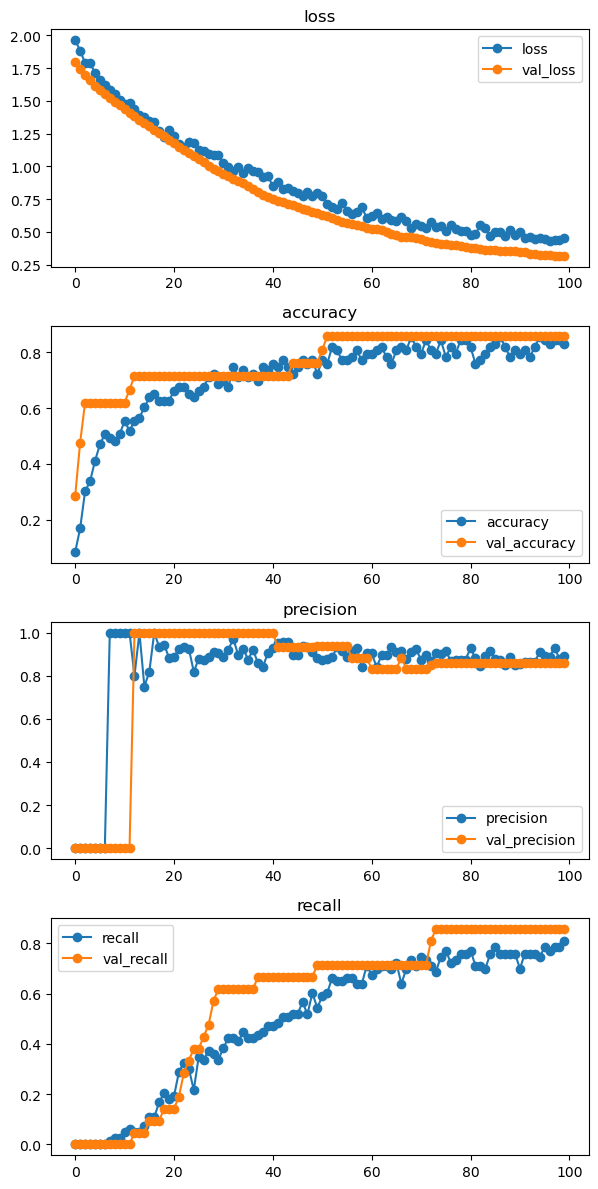

In [18]:
# Plot learning history
plot_history(history);

The learning converges on fairly good scores according to our accuracy, precision, and recall metrics. There is no severe underfitting. We also see that the final training scores and testing scores are pretty close. The model is not overfitting overly much.

The metrics along the training history are somewhat bumpy. This is likely caused by the dropout layer, small dataset, and class imbalance.

## Evaluate the Multiclass Classification Model

There are differences in how we process the model predictions to use Sci-Kit Learn evaluation functions. Sci-Kit Learn expects a one-dimensional array of predictions and labels, but our predictions and binarized labels are two-dimensional. Each column represents a different fish species, and the values in each column represent the model’s estimation of the probability that the fish belongs to that species.

Notice that these are represented in scientific notation, for example:

9.2e-03 = 0.0092

9.8e-01 = 0.98

In [19]:
# get raw predictions
raw_pred = multi_model.predict(X_test_tf)
 
# display predictions and binarized true labels
print('Raw Predictions\n', raw_pred[:5])
print('\nbinarized y_test\n', y_test_bin[:5])

2/2 [==============================] - 0s 2ms/step
Raw Predictions
 [[2.3807548e-03 3.2593267e-05 9.6624571e-01 4.4492614e-03 5.4690794e-05
  8.4326921e-06 2.6828552e-02]
 [1.7956376e-02 4.8797969e-02 5.0128335e-01 1.6373796e-02 3.2792413e-01
  3.1174302e-02 5.6490071e-02]
 [1.9547704e-03 5.9374049e-02 4.5363864e-01 2.7157462e-03 2.4400549e-01
  2.2479296e-01 1.3518424e-02]
 [1.6883377e-02 2.5170317e-04 9.0725034e-01 1.2742345e-02 2.4727371e-04
  5.8945272e-05 6.2566012e-02]
 [9.9071795e-01 4.1579399e-03 1.9209029e-03 2.6289755e-04 1.4689946e-04
  5.7127392e-05 2.7362150e-03]]

binarized y_test
 [[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0]]


To use these predictions in a Sci-kit Learn function, we need to convert them to the integer label for each fish. We can do that with np.argmax(data, axis=1). This will return the column index for the highest value in each row. That column index corresponds to the fish species.

In [20]:
# convert predictions and labels into integers representing each fish class.
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)
 
print('integer predictions', y_pred)
print('integer true labels', y_true)

integer predictions [2 2 2 2 0 2 5 3 2 0 2 0 3 2 0 2 2 2 2 0 1 3 0 5 2 2 5 0 0 1 2 0 2 2 2]
integer true labels [2 2 2 6 0 2 5 3 2 0 2 0 3 2 0 4 2 2 4 0 1 3 1 4 4 2 5 0 0 1 6 0 5 2 2]


Now we are ready to use Sci-kit learn tools to evaluate our model. Let’s use a classification report and a confusion matrix.

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.67      0.80         3
           2       0.67      1.00      0.80        12
           3       1.00      1.00      1.00         3
           4       0.00      0.00      0.00         4
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         2

    accuracy                           0.77        35
   macro avg       0.60      0.62      0.60        35
weighted avg       0.66      0.77      0.70        35



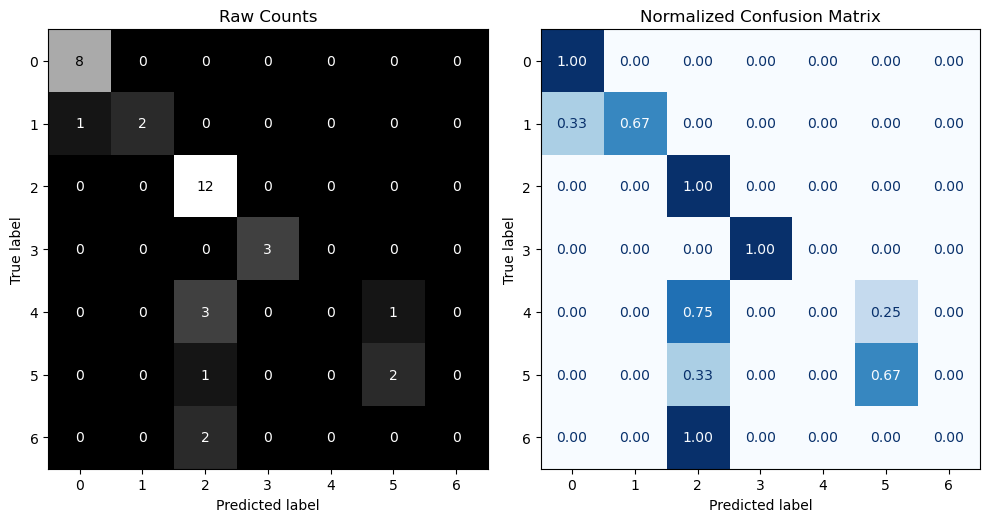

In [21]:
# Getting Sklearn Metrics
classification_metrics(y_true, y_pred, label='Test Data', figsize=(10,8))

**Model Evaluation**

Our model correctly classified 77% of the fish. However, it was unable to classify Whitefish or Roach. This is likely because very few of those fish are in the dataset. Again, we run into the problem of a too-small dataset.

## Summary

Multiclass classification in Keras has some special requirements. The labels should be binarized or one-hot encoded. The final output layer must have a number of nodes equal to the number of classes and an activation function of ‘softmax.’ When compiling the model, the loss function should be ‘categorical_crossentropy.’ When evaluating the model using Sci-kit Learn metrics functions, it is first necessary to convert the 2-dimensional prediction and label arrays to one dimension by using np.argmax(data, axis=1). Once these are done, you can proceed with evaluation in the same way as you would with traditional Sci-kit Learn models.

